In [2]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

In [140]:
import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\logistic_det"

my_path = os.path.abspath(__file)

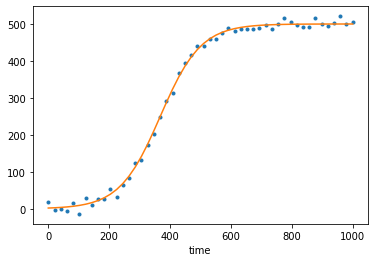

In [5]:
# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = np.array([0.015, 500])
times = np.linspace(0, 1000, 50)
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.plot(times, values, '.')
plt.plot(times, org_values)
plt.xlabel('time')
plt.show()

In [11]:
log_prior = pints.UniformLogPrior(
    [0.01, 450],
    [0.02, 560]
)

# Running 3 chains of NUTS

In [123]:
model = toy.LogisticModel()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 450],
    [0.02, 560]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.1,
]

# Create mcmc routine
nuts_mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.NoUTurnMCMC)
nuts_mcmc.set_max_iterations(1000)

# Set up modest logging
nuts_mcmc.set_log_to_screen(True)
nuts_mcmc.set_log_interval(100)

# Run!
print('Running...')
nuts_chains = nuts_mcmc.run()
print('Done!')


Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     39     0.375    1       0.389    1       0.375    2        0:00.0
1     42                      0.25     1       0.25     1        0:00.0
2     45     0.125    2       0.5      1       0.25     1        0:00.0
3     48                      0.25     1       0.25     1        0:00.0


d:\Part B\repos\pints\pints\toy\_logistic_model.py:74: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-r * times)
d:\Part B\repos\pints\pints\toy\_logistic_model.py:81: RuntimeWarning: overflow encountered in square
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
d:\Part B\repos\pints\pints\toy\_logistic_model.py:81: RuntimeWarning: invalid value encountered in true_divide
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
d:\Part B\repos\pints\pints\toy\_logistic_model.py:83: RuntimeWarning: overflow encountered in square
  (self._p0 * (c * exp + 1)**2) + 1 / (c * exp + 1)
d:\Part B\repos\pints\pints\toy\_logistic_model.py:82: RuntimeWarning: invalid value encountered in true_divide
  dvalues_dp[:, 1] = -k * exp / \
d:\Part B\repos\pints\pints\toy\_logistic_model.py:77: RuntimeWarning: overflow encountered in multiply
  values = k / (1 + c * exp)
d:\Part B\repos\pints\pints\toy\_logistic_model.py:81: RuntimeWarning: overflow encountered in multiply
  d

100   107592  0.783    366     0.78     327     0.783    276      0:19.1
200   196575  0.770297 294     0.802962 64      0.826    44       0:34.5
300   225456  0.775    105     0.904676 52      0.887    46       0:39.6
400   234940  0.792    47      0.876    54                        0:41.3
500   242210  0.781731 36      0.887    41                        0:42.7
600   248572  0.92     51      0.845    53                        0:44.0
700   252966  0.911    44                                         0:44.8
800   258042  0.908446 51                                         0:45.8
900   262902  0.91     49                                         0:46.8
1000  266893  0.921    40                                         0:47.6
Halting: Maximum number of iterations (1000) reached.
Done!


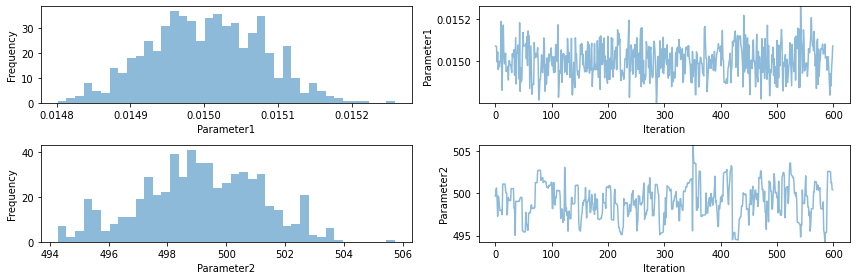

R-hat:
[1.00014328 1.00977871]


In [133]:
nuts_chains = nuts_chains

pints.plot.trace([nuts_chains[0, :]])
plt.show()

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat(nuts_chains))

# Creating a stochastic process

In [8]:
class ErrorLogisticModel(pints.ForwardModelS1, pints.toy.ToyModel):
    def __init__(self, initial_population=2):
        super(ErrorLogisticModel, self).__init__()
        self._model = toy.LogisticModel(initial_population)
    
    def n_parameters(self):
        return 2
    
    def simulate(self, parameters, times):
        org_values = self._model.simulate(parameters, times)
        return org_values + np.random.normal(0, noise, org_values.shape)

    def suggested_parameters(self):
        return np.array([0.1, 50])
    
    def suggested_times(self):
        return np.linspace(0, 100, 100)

In [9]:
s_model = ErrorLogisticModel()
problem = pints.SingleOutputProblem(s_model, times, values)
error_measure = pints.RootMeanSquaredError(problem)

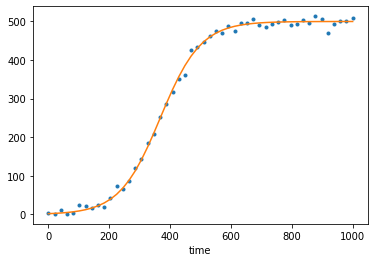

In [24]:

# Create some toy data
real_parameters = np.array([0.015, 500])
times = np.linspace(0, 1000, 50)
values = s_model.simulate(real_parameters, times)

plt.plot(times, values, '.')
plt.plot(times, org_values)
plt.xlabel('time')
plt.show()

# Running ABC Rejection

In [19]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(13)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     503    0.00198807157    0:00.1
2     2605   0.000767754319   0:00.3
3     4479   0.000669792364   0:00.4
20    21345  0.000936987585   0:01.8
40    41056  0.000974279034   0:03.4
60    59425  0.00100967606    0:04.9
80    73611  0.00108679409    0:06.0
100   93273  0.00107212162    0:07.5
120   107936  0.00111176994    0:08.7
140   120784  0.00115909392    0:09.7
160   132400  0.00120845921    0:10.6
180   145812  0.0012344663     0:11.7
200   159869  0.00125102428    0:12.8
220   174504  0.00126071609    0:13.9
240   193478  0.00124045111    0:15.3
260   205163  0.00126728504    0:16.3
280   219946  0.00127303975    0:17.5
300   234143  0.00128126828    0:18.6
320   248491  0.001287773      0:19.7
340   266446  0.00127605594    0:21.1
360   279859  0.00128636206    0:22.2
380   311428  0.00122018573    0:24.6
400   323983  0.00123463268    0:25.6
420   342257  0.00122714802    0:27.0


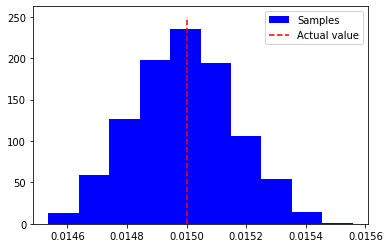

In [20]:
samples_flat = np.array([item for sublist in samples for item in sublist])

# print(samples_flat[:])
plt.hist(samples_flat[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

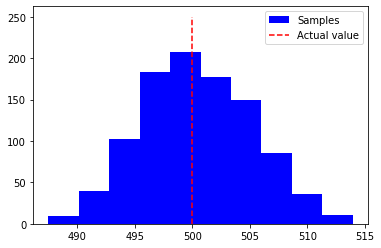

In [21]:
plt.hist(samples_flat[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

In [25]:
samples_abc_rej = samples_flat

[]

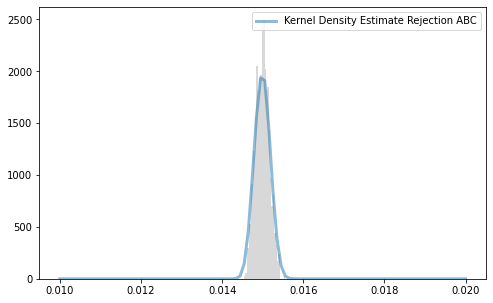

In [33]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

[]

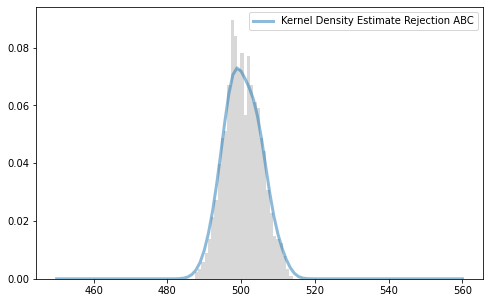

In [35]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

# ABC PMC

In [36]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([20, 15, 13]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(1000)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=15
Trying t=2, threshold=13
Iter. Eval. Acceptance rate Time m:s
1     63018  1.5868482e-05    1:53.1
2     63168  3.16616008e-05   1:53.5
3     63717  4.7083196e-05    1:54.7
20    67523  0.00029619537    2:03.7
40    71157  0.000562137246   2:13.0
60    74079  0.000809946139   2:20.6
80    77744  0.00102901832    2:29.4
100   81014  0.00123435456    2:36.9
120   84377  0.00142218851    2:45.0
140   87324  0.00160322477    2:51.8
160   90300  0.00177187154    2:58.6
180   92957  0.00193637919    3:04.8
200   96082  0.00208155534    3:12.0
220   99671  0.00220726189    3:20.2
240   103326  0.00232274549    3:28.9
260   106468  0.00244204831    3:39.3
280   110257  0.0025395213     3:48.6
300   114771  0.00261390072    3:59.7
320   117924  0.00271361216    4:10.0
340   122697  0.0027710539     4:28.9
360   125882  0.0028598211     4:37.0
380   128640  0.0029539801     4:44.2
400   131567  0.00304027606    4:51.6
420   13461

In [37]:
samples_pmc_true = samples

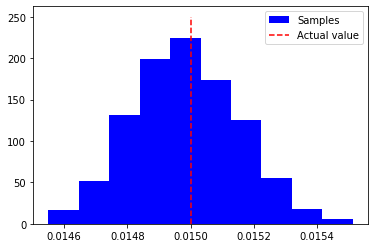

In [38]:
plt.hist(samples_pmc_true[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

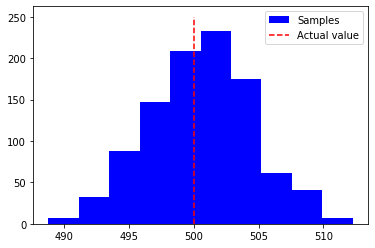

In [39]:
plt.hist(samples_pmc_true[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

[]

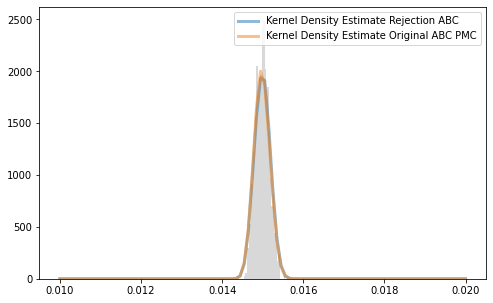

In [41]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Original ABC PMC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

[]

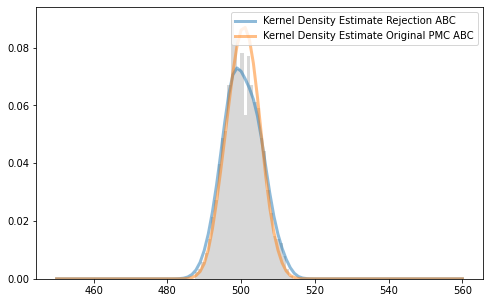

In [42]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

# PMC Modified

In [59]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([20, 15, 13]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=15
Trying t=2, threshold=13
Iter. Eval. Acceptance rate Time m:s
1     11852  8.43739453e-05   0:11.8
2     12087  0.000165467031   0:12.2
3     12289  0.000244120758   0:12.5
20    14917  0.00134075216    0:16.2
40    17892  0.00223563604    0:20.6
60    20827  0.00288087579    0:24.9
80    24815  0.00322385654    0:31.1
100   27572  0.00362686784    0:35.9
120   30983  0.0038730917     0:40.4
140   34571  0.00404963698    0:45.4
160   38359  0.00417112021    0:50.9
180   43264  0.00416050296    0:58.1
200   46548  0.00429664003    1:02.6
220   48908  0.0044982416     1:05.7
240   51469  0.00466300103    1:09.3
260   54957  0.00473097149    1:14.5
280   57952  0.00483158476    1:18.7
300   62320  0.00481386393    1:25.2
320   65040  0.0049200492     1:29.3
340   68123  0.00499097221    1:33.9
360   70312  0.00512003641    1:37.3
380   73225  0.00518948447    1:41.4
400   75867  0.00527238457    1:45.2
420   80126  0.00524

In [60]:
samples_pmc_fake = samples

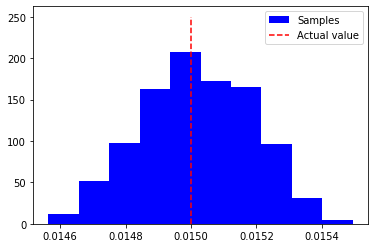

In [61]:
plt.hist(samples_pmc_fake[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

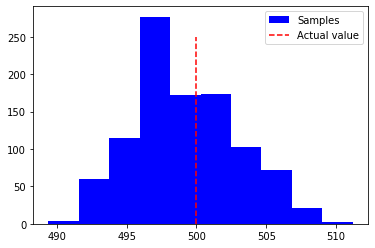

In [62]:
plt.hist(samples_pmc_fake[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

[]

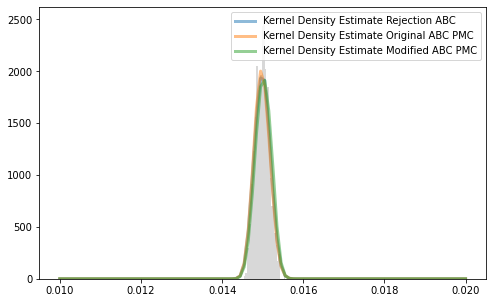

In [63]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Original ABC PMC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Modified ABC PMC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

[]

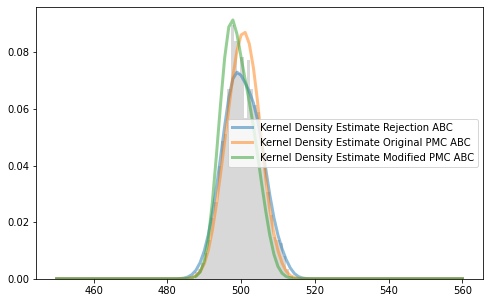

In [64]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

# ABC Adaptive PMC

In [71]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

# set threshold
abc.sampler().set_N_l(900)

# set p_acc_min
abc.sampler().set_p_acc_min(0.05)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[1.54588125e-02 5.08047749e+02]
resulting var=[[ 1.34415153e-05 -1.23955828e-02]
 [-1.23955828e-02  2.05697537e+03]]
epsilon=84.94175194367752
w_mean=[1.57286520e-02 5.02866089e+02]
resulting var=[[ 1.20371504e-05 -1.97532419e-02]
 [-1.97532419e-02  1.99395559e+03]]
epsilon=74.91120256490521
w_mean=[1.54718852e-02 5.03554712e+02]
resulting var=[[ 1.03586466e-05 -3.84090764e-02]
 [-3.84090764e-02  1.98895904e+03]]
epsilon=68.81644691904575
w_mean=[1.56012178e-02 5.03308792e+02]
resulting var=[[ 8.59356903e-06 -3.29454328e-02]
 [-3.29454328e-02  1.82131229e+03]]
epsilon=63.90070883253226
w_mean=[1.54310825e-02 5.03163378e+02]
resulting var=[[ 7.32262955e-06 -3.30245370e-02]
 [-3.30245370e-02  1.79811117e+03]]
epsilon=59.970892565648136
w_mean=[1.53364281e-02 5.03756163e+02]
resulting var=[[ 6.40464268e-06 -3.30158683e-02]
 [-3.30158683e-02  1.80059712e+03]]
epsilon=55.750338862839165
w_mean=[1.52700053e-02 5.03095271e+0

In [72]:
samples_adaptive = samples

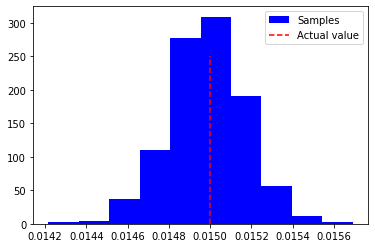

In [73]:
plt.hist(samples_adaptive[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

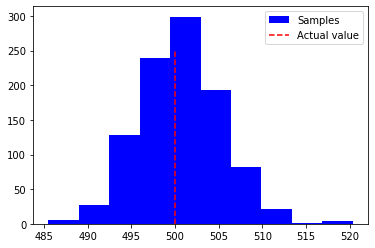

In [74]:
plt.hist(samples_adaptive[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

[]

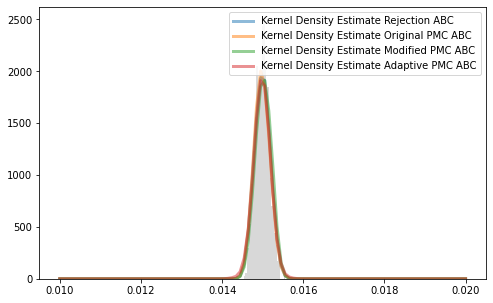

In [75]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))


ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

[]

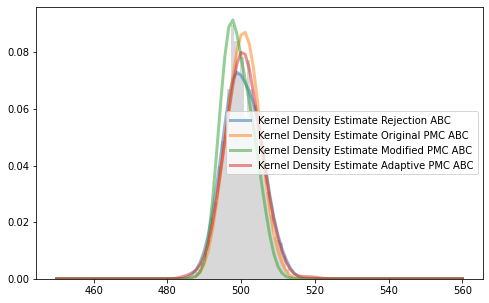

In [76]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

# Hamiltonian ABC

In [78]:
from scipy.stats import multivariate_normal

class ActuallySyntheticLikelihood:
    def __init__(self, y, eps):
        y = np.array(y)
        if len(y.shape) == 1:
            self._y = np.array([y])
        else:
            self._y = np.array(y)
        self._eps = eps
        if isinstance(self._eps, (list, tuple, np.ndarray)):
            self._eps = np.diag(np.square(self._eps))

    def pdf(self, vals):   
        # estimate mean
        t_mean = np.zeros((len(self._y), len(self._y[0])))
        
        for j in range(len(self._y)):
            for i in range(len(vals)):
                t_mean[j] += vals[i][j]
            t_mean[j] /= (len(vals))
        
        t_cov = np.zeros( (len(self._y), len(self._y[0]), len(self._y[0])) )
        
        for i in range(len(self._y)):
            for j in range(len(vals)):
                one_t = np.array([vals[j][i] - t_mean[i]])
                t_cov[i] += one_t * np.transpose(one_t)
            
            t_cov[i] /= (len(vals) - 1)
            t_cov[i] += self._eps
            
        rez = 0
        
        for i in range(len(self._y)):
            rez += (multivariate_normal.pdf(self._y[i], mean=t_mean[i], cov=t_cov[i]))


        rez = np.log(rez)
        return rez

In [101]:
class HABCsgld:
    def __init__(self, T, theta0, m, eps, s_eps, log_prior, sim_f, c, y):
        self._T = T
        self._theta0 = theta0
        self._dim = len(theta0)
        self._m = m
        self._eps = eps
        self._c = c
        self._cnt = 0
        self._mean = np.zeros(self._dim)
        
        # Functions
        self._log_prior = log_prior
        self._grad_prior = self.grad_pr 
        self._sim_f = sim_f
        self._cnt_samples = 0
        
        # Build synthetic likelihood
        self._synt_l = ActuallySyntheticLikelihood(y, s_eps)
        
        self._grads = []
    
    def grad_pr(self, theta):
        x, dx = self._log_prior.evaluateS1(theta)
        return dx
    
    def spsa(self, theta, d_theta, S, R):
        self._grads = None
        if (len(theta.shape) > 1):
            dim = len(theta[0])
        else:
            dim = len(theta)
        g = np.zeros(dim)
        
        for r in range(R):
            # Generate bernoulli distribution vector
            delta = np.zeros(dim)
            for i in range(dim):
                delta[i] = (2 * np.random.binomial(n=1, p=0.5) - 1)
            
            
            set_plus = None
            set_minus = None
            
            aux = 0
            
            for s in range(S):
                x_plus = self._sim_f(theta + d_theta * delta)
                x_minus = self._sim_f(theta - d_theta * delta)
                self._cnt_samples += 2
                
                if len(x_plus.shape) == 1:
                    x_plus = [[x] for x in x_plus]
                if len(x_minus.shape) == 1:
                    x_minus = [[x] for x in x_minus]
                    
                if set_plus is None:
                    set_plus = [x_plus]
                    set_minus = [x_minus]
                else:
                    set_plus.append(x_plus)
                    set_minus.append(x_minus)
            term = (self._synt_l.pdf(set_plus) - self._synt_l.pdf(set_minus)) * delta
            g += term

        g = ( 1 / (2 * d_theta * R) ) * g
        
        grad_val = self.grad_pr(theta)
        # if len(grad_val.shape) > 1:
            # grad_val = grad_val[0]
        g += np.exp(grad_val)
        
        return -g
        
    def run(self):
        # Initialize stuff
        self._results = [self._theta0]
        
        for t in range(1, self._T):
            done = False
            
            while not done:
                # Resample momentum
                
                curr_theta = self._results[t-1]
                curr_momentum = np.random.multivariate_normal(np.zeros(self._dim), np.eye(self._dim))
                
                i = 0
                problem = False
                
                while not problem and i <= self._m:
                    spsa_term = self.spsa(curr_theta, 0.0001, S=2, R=2)
                    next_theta = curr_theta + self._eps * np.random.normal(0, np.eye(self._dim)) - \
                                 (self._eps ** 2) / 2 * spsa_term
                    # print("next theta computed="+str(next_theta))
                    if self._log_prior(next_theta + 0.0001 * np.ones(self._dim)) == np.NINF \
                        or self._log_prior(next_theta - 0.0001 * np.ones(self._dim)) == np.NINF:
                        print("NEXT THETA REMOVED="+str(next_theta))
                        problem = True
                    else:
                        
    #                     print("spsa_term=" + str(spsa_term * self._eps))
    #                     print("second term=" + str(self._eps * self._C * curr_momentum))
    #                     print("third term=" + str(np.random.multivariate_normal(np.zeros(self._dim), 2 * self._eps * (self._C - self._B))))
    #                     print("next_theta="+str(next_theta))
    #                     print("next_momentum="+str(next_momentum))
                        curr_theta = next_theta
                        if self._log_prior(curr_theta) == np.NINF:
                            problem = True
                        i = i + 1
                if not problem:
                    done = True
                    self._results.append(curr_theta)
            print("t= " + str(t) + ", " + "curr_theta =" + str(curr_theta))
        
        print("count samples = "+str(self._cnt_samples))
        return self._results

In [116]:
np.random.seed(1)

y = np.array([[x] for x in values])

theta0 = np.array([0.012, 480])

def grad_prior(theta):
    x, dx = log_prior.evaluateS1(theta)
    return dx

# Simulating function
def sim_f(theta):
#     print("trying " + str(theta))
    if len(theta.shape) == 2:
        theta = theta[0]
#     print("in the end we have " + str(theta))
    return s_model.simulate(theta, times)

# seed 1,  0.0005, 0.05
abc = HABCsgld(1000, theta0, 10, np.array([0.0005, 0.05]), 0.1, log_prior, sim_f, 0.001, y)

print("abc started")        

results = abc.run()

print("abc finished")
print(results)

abc started
NEXT THETA REMOVED=[[9.56469178e-03 4.80670507e+02]
 [1.24882022e-02 4.80648360e+02]]
t= 1, curr_theta =[[1.49428133e-02 4.83188706e+02]
 [1.29290516e-02 4.83154398e+02]]
t= 2, curr_theta =[[1.31329069e-02 4.85225782e+02]
 [1.34514529e-02 4.85260417e+02]]
t= 3, curr_theta =[[1.41488574e-02 4.85521829e+02]
 [1.46770515e-02 4.85683900e+02]]
t= 4, curr_theta =[[1.56825861e-02 4.86121226e+02]
 [1.56787806e-02 4.86309623e+02]]
t= 5, curr_theta =[[1.82208241e-02 4.85068530e+02]
 [1.58532454e-02 4.85420075e+02]]
t= 6, curr_theta =[[1.43569485e-02 4.84054965e+02]
 [1.51750122e-02 4.84374050e+02]]
t= 7, curr_theta =[[1.55934704e-02 4.84239423e+02]
 [1.53810848e-02 4.84513354e+02]]
t= 8, curr_theta =[[1.55388875e-02 4.84455537e+02]
 [1.64022213e-02 4.84758541e+02]]
t= 9, curr_theta =[[1.56051709e-02 4.83472001e+02]
 [1.69365791e-02 4.83700526e+02]]
t= 10, curr_theta =[[1.55889736e-02 4.83653467e+02]
 [1.64874236e-02 4.83820735e+02]]
t= 11, curr_theta =[[1.76192067e-02 4.84595011e+02]

In [109]:
samples_hamiltonian = np.array([x for z in results[2:] for x in z])

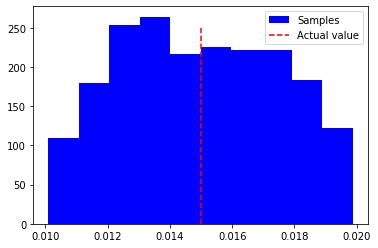

In [111]:
plt.hist(samples_hamiltonian[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

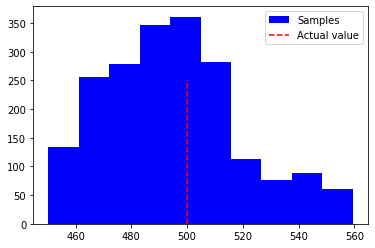

In [112]:
plt.hist(samples_hamiltonian[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

In [117]:
samples_hamiltonian2 = np.array([x for z in results[2:] for x in z])

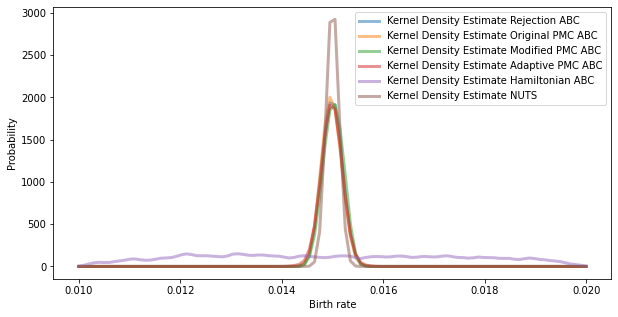

In [160]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10, 5))


ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_hamiltonian)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(nuts_chains[0, :])[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate NUTS', linewidth=3, alpha=0.5)
# ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
# ax.plot()
plt.ylabel("Probability")
plt.xlabel("Birth rate")
plt.savefig(my_path + './logistic_det_kde_x.pdf')

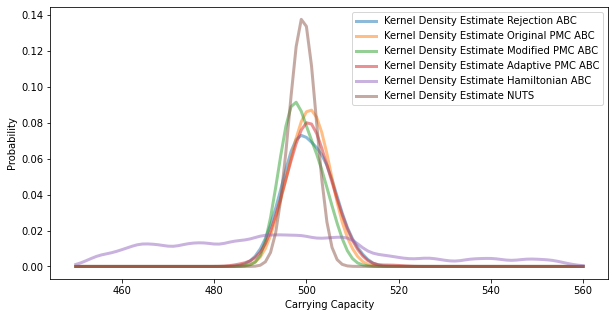

In [159]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_hamiltonian)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(nuts_chains[0, :])[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate NUTS', linewidth=3, alpha=0.5)
# ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
plt.ylabel("Probability")
plt.xlabel("Carrying Capacity")
# ax.plot()
plt.savefig(my_path + './logistic_det_kde_y.pdf')

# Compute KL

In [157]:
from scipy import integrate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

def kl_func_x(y, kde_skl):
    part = kde_sklearn(np.array(nuts_chains[0, :])[:, 0], np.array([y]), bandwidth=0.0001)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if part == 0:
        return 0
    elif s_part == 0:
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_x(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_x(y, kde_skl)
    return integrate.quad(fun, 0.1, 0.)

def kl_func_y(y, kde_skl):
    part = kde_sklearn(np.array(nuts_chains[0, :])[:, 1], np.array([y]), bandwidth=2)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_y(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_y(y, kde_skl)
    return integrate.quad(fun, 450, 560)

saved_abc_rej = kl_div_x(np.array(samples_abc_rej)[:, 0], 0.0001)[0] + kl_div_y(np.array(samples_abc_rej)[:, 1], 2)[0]
saved_fake_pmc = kl_div_x(np.array(samples_pmc_fake)[:, 0], 0.0001)[0] + kl_div_y(np.array(samples_pmc_fake)[:, 1], 2)[0]
saved_orig_pmc = kl_div_x(np.array(samples_pmc_true)[:, 0], 0.0001)[0] + kl_div_y(np.array(samples_pmc_true)[:, 1], 2)[0]
saved_adaptive = kl_div_x(np.array(samples_adaptive)[:, 0], 0.0001)[0] + kl_div_y(np.array(samples_adaptive)[:, 1], 2)[0]
saved_hamiltonian = kl_div_x(np.array(samples_hamiltonian)[:, 0], 0.0001)[0] + kl_div_y(np.array(samples_hamiltonian)[:, 1], 2)[0]

print("ABC REJ KL = " + str(saved_abc_rej))
print("MOD PMC KL = " + str(saved_fake_pmc))
print("ORIG PMC KL = " + str(saved_orig_pmc))
print("ADAPTIVE KL = " + str(saved_adaptive))
print("HAMILTONIAN KL = " + str(saved_hamiltonian))

ABC REJ KL = 0.2891666015729325
MOD PMC KL = 0.15752222776387667
ORIG PMC KL = 0.21302298747298168
ADAPTIVE KL = 0.2680267617645204
HAMILTONIAN KL = 1.6186503566356367


# Data

In [67]:
print(samples_abc_rej.tolist())

[[0.014911169714646384, 495.6026448548122], [0.014867011131772415, 508.85743240340895], [0.014896424733339662, 506.52407835279934], [0.015025145820575419, 496.68211839833276], [0.015075873333388078, 507.05592137259566], [0.015168300929265452, 493.18797123423366], [0.01491013751263277, 503.18318162269077], [0.014718343669454851, 505.6377503397744], [0.014993287702000025, 501.9639566990596], [0.014956414784113888, 503.119529261914], [0.015193678622154441, 497.50066172896317], [0.014756085210463437, 503.7966293496393], [0.015037470348970097, 499.75428323683184], [0.01518293281558746, 500.75767115778865], [0.014671509801899612, 505.2353364951725], [0.015304381094636766, 503.1710446133351], [0.01518752185269415, 498.4099162064], [0.015382035751139818, 495.10960482668673], [0.015089916185151722, 492.4294720044254], [0.015098471022718472, 499.81593372363756], [0.0151338997653141, 503.9955373648744], [0.015170221485302098, 497.50241690019106], [0.014942390761158731, 506.5868147272519], [0.0149

In [68]:
print(samples_pmc_fake.tolist())

[[0.015064334246469576, 497.04839590867243], [0.01539090065922834, 493.42733852648576], [0.01501711748166196, 502.5505279681551], [0.014717790684589763, 505.339142531856], [0.01494100085864561, 507.1710141103342], [0.015101420789487932, 496.65517372464427], [0.01478874956866193, 504.2704743687647], [0.014908418235244695, 499.9073103269556], [0.014949155355267271, 496.0513041128469], [0.014881212378134171, 503.12638882700674], [0.015057713595567642, 500.8175152353979], [0.014953648637884192, 496.4680382042844], [0.015211086980234477, 498.41281537934793], [0.014870881662791489, 500.8678619665123], [0.0151260045946819, 494.007355566538], [0.015177825561539604, 497.4176703974192], [0.015124897204756379, 506.1779994744056], [0.01468432910103613, 503.9090241832483], [0.014909927957952296, 496.4488968081954], [0.015181799538684477, 497.77533563728053], [0.01481068272697805, 504.14210644380347], [0.01499800279950855, 501.0453846640148], [0.015390261739154289, 501.0563963768616], [0.01503268408

In [69]:
print(samples_pmc_true.tolist())

[[0.014921649188130836, 497.9705838085952], [0.015073184045095613, 496.4482671524947], [0.015201963183042804, 498.3380581015152], [0.015045214386362828, 501.4432990224519], [0.015030979857956876, 506.1013275211077], [0.01496063492872043, 494.9127229425021], [0.014807614423419062, 504.5151845421797], [0.015046542847175682, 501.5541496616409], [0.01501247124611871, 502.4877990293071], [0.015251324334351174, 498.5165994671536], [0.014995051050833997, 501.48800407398994], [0.015244328635824611, 501.4567397329548], [0.015032521411505184, 505.6016041743762], [0.014755904523733017, 502.71746570613135], [0.01527150495101351, 499.63021283505407], [0.014961018218662005, 500.67230500872773], [0.01497354285693011, 504.78059331864256], [0.015056653368595267, 499.8129685440382], [0.015193957954126817, 501.3968840433423], [0.014997519247300353, 510.0318888526786], [0.015160936884720812, 498.0298263548332], [0.01493043586466972, 500.6374911296934], [0.015019903192645854, 498.0882642150841], [0.0146693

In [77]:
print(samples_adaptive.tolist())

[[0.01482854384717369, 503.46358138954565], [0.015213458844371145, 495.86656493533854], [0.014733891529428717, 504.8450426465249], [0.014978750055768306, 498.42790575561634], [0.01489150598444582, 499.0036535157644], [0.014818348635809372, 501.31444482747486], [0.01486976312412543, 497.8224750493638], [0.015226894143252089, 491.03890242693876], [0.0149097669673972, 495.0933555868971], [0.014958639608449058, 501.6318291840098], [0.01473297569976461, 497.5356255219799], [0.014833925849740514, 498.1033388396007], [0.015072805029080273, 498.4061795408121], [0.0152292202951635, 503.0876410630411], [0.014733120892327199, 509.488823179195], [0.014779095864109072, 499.4663458867896], [0.014984171580192057, 495.88138447533873], [0.014947497511110684, 505.43822943111326], [0.015033930220552778, 507.62825950101484], [0.015057101605534428, 498.6420282988914], [0.01488576926439845, 497.57683678632924], [0.015022483210050707, 500.01199991782744], [0.0152789922985236, 496.16498544220065], [0.01517062

In [143]:
print(samples_hamiltonian.tolist())

[[0.012224892097944416, 505.02225962594605], [0.01254343809716508, 505.10884911132683], [0.012735290187125858, 494.7412977958163], [0.013263484294028323, 495.1464757138724], [0.013034326244502459, 494.95593560644545], [0.013030520675951769, 495.4269275841503], [0.01571755515007811, 499.7782016621689], [0.01334997646782478, 500.6570644845561], [0.012363383221777179, 490.86250456267555], [0.013181446856143555, 491.66021847432233], [0.013317285467851703, 493.7290108622738], [0.013104899786578255, 494.4138388470916], [0.01252451682720967, 494.72847045158704], [0.013387850656357132, 495.4859818738541], [0.012335794577206068, 497.102185125928], [0.013667202795500216, 497.6734960299961], [0.012724855152962513, 502.2519007405225], [0.013623305131193557, 502.67007036257974], [0.0146969061374973, 504.3849868755295], [0.013685790936287794, 504.74270329823406], [0.011888187359071167, 500.71743046123544], [0.013180580054622287, 500.98057510070515], [0.011620296021590844, 501.42636013449663], [0.013